# Audio File EDA, Image Creation, Pre-processing, FSM

- Converting the the audio files to square Mel-spectrograms, and saving in spectrograms/(BigRoom, DrumAndBass, Techno)
- Applying pre-processing
- FSM CNN with TensorFlow

In [25]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("Blues", as_cmap=True)

# Standard Packages
import numpy as np
import warnings
import pandas as pd
import os
import shutil
import random
import time
import PIL
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#for loading and visualizing audio files
import librosa
import librosa.display
from scipy import signal
from scipy.io import wavfile
import wave

#to play audio
import IPython.display as ipd

### Getting list of genre_names and setting the audio_fpath variable

In [2]:
audio_fpath = "../data/subgenre_dataset/"
genre_names = os.listdir(audio_fpath)
print(genre_names)

['Breaks', 'BigRoom', 'PsyTrance', 'TechHouse', 'ReggaeDub', 'ElectronicaDowntempo', '.DS_Store', 'IndieDanceNuDisco', 'HardcoreHardTechno', 'Trance', 'Minimal', 'ElectroHouse', 'Dance', 'DrumAndBass', 'HipHop', 'GlitchHop', 'House', 'HardDance', 'ProgressiveHouse', 'FutureHouse', 'FunkRAndB', 'Dubstep', 'DeepHouse', 'Techno']


### Getting list of file paths for the 3 selected genres

In [3]:
big_room_file_paths = [audio_fpath + 'BigRoom/' + f for f in os.listdir(audio_fpath + 'BigRoom/') if '.wav' in f]
# big_room_file_paths

In [4]:
dnb_file_paths = [audio_fpath + 'DrumAndBass/' + f for f in os.listdir(audio_fpath + 'DrumAndBass/') if '.wav' in f]
# dnb_file_paths

In [5]:
techno_file_paths = [audio_fpath + 'Techno/' + f for f in os.listdir(audio_fpath + 'Techno/') if '.wav' in f]
# techno_file_paths

## Image pre-processing

### Data has already been train, validate, test split

#### We use Generators because we want to be able to expand this to larger datasets
This means we need to use fit_generator and predict_generator functions during training and testing

In [6]:
# Setting batch size to 1/10 the size of the dataset. Image width and height already loads in as 256x256

batch_size = 30
img_height = 256
img_width = 256
num_channels = 1  # It is grayscale. RGB would be 3


# Set the root directory containing the subdirectories for each class
root_dir = '../spectrograms/quarters/'

# Create the train, validation, and test directories
train_dir = root_dir + 'train/'
val_dir = root_dir + 'validate/'
test_dir = root_dir + 'test/'

#### Without rescaling

In [6]:
# # Create data generators for the train, validation, and test sets

# # Need to look into the rescale value. This is the scaling used for color images. Should it be different for grayscale?

# train_data_gen = ImageDataGenerator().flow_from_directory(
#         directory=train_dir,
#         target_size=(img_height, img_width),
#         color_mode='grayscale',
#         batch_size=batch_size,
#         class_mode='categorical')

# validation_data_gen = ImageDataGenerator().flow_from_directory(
#         directory=val_dir,
#         target_size=(img_height, img_width),
#         color_mode='grayscale',
#         batch_size=batch_size,
#         class_mode='categorical')

# test_data_gen = ImageDataGenerator().flow_from_directory(
#         directory=test_dir,
#         target_size=(img_height, img_width),
#         color_mode='grayscale',
#         batch_size=batch_size,
#         class_mode='categorical')

Found 957 images belonging to 3 classes.
Found 120 images belonging to 3 classes.
Found 123 images belonging to 3 classes.


#### With Re-scaling

In [7]:
# Create data generators for the train, validation, and test sets

# Need to look into the rescale value. This is the scaling used for color images. Should it be different for grayscale?

train_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory=train_dir,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

validation_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory=val_dir,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

test_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory=test_dir,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

Found 957 images belonging to 3 classes.
Found 120 images belonging to 3 classes.
Found 123 images belonging to 3 classes.


## FIRST FSM

In [23]:
lr = 0.5e-3
stride = 2
padding = 'same'     # Temporary padding selection - STILL NEED TO IMPLEMENT
kernel_size = (3, 3)
input_shape=(img_height, img_width, num_channels)

In [13]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 246016)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

### 8 Epochs first CNN Training

Changed lr to 0.5e-3. Doing this one with rescaling

In [16]:
start_time = time.time()
history = model.fit_generator(
        train_data_gen,
        steps_per_epoch=train_data_gen.samples // batch_size,
        epochs=8,
        validation_data=validation_data_gen,
        validation_steps=validation_data_gen.samples // batch_size,
        workers=8,
)
print(time.time() - start_time)

Epoch 1/8


2023-04-11 10:57:29.861737: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


31/31 [==============================] - 120s 3s/step - loss: 1.5457 - acc: 0.3700 - val_loss: 1.0562 - val_acc: 0.5917
Epoch 2/8
31/31 [==============================] - 113s 3s/step - loss: 0.9547 - acc: 0.5739 - val_loss: 0.8599 - val_acc: 0.6333
Epoch 3/8
31/31 [==============================] - 98s 3s/step - loss: 0.7603 - acc: 0.6861 - val_loss: 0.7100 - val_acc: 0.7083
Epoch 4/8
31/31 [==============================] - 121s 3s/step - loss: 0.6203 - acc: 0.7681 - val_loss: 0.6403 - val_acc: 0.7167
Epoch 5/8
31/31 [==============================] - 120s 3s/step - loss: 0.4659 - acc: 0.8296 - val_loss: 0.5313 - val_acc: 0.8167
Epoch 6/8
31/31 [==============================] - 112s 3s/step - loss: 0.3646 - acc: 0.8630 - val_loss: 0.4604 - val_acc: 0.8333
Epoch 7/8
31/31 [==============================] - 115s 3s/step - loss: 0.2533 - acc: 0.9301 - val_loss: 0.7579 - val_acc: 0.7250
Epoch 8/8
31/31 [==============================] - 115s 3s/step - loss: 0.1555 - acc: 0.9698 - val_lo

In [13]:
# model_loss, model_acc = model.evaluate_generator(test_data_gen, steps=len(test_data_gen))
# print('Model evaluation accuracy:', model_acc)

In [17]:
# Get the predictions for the test set
test_predictions_percentages = model.predict_generator(test_data_gen, steps=test_data_gen.samples // batch_size + 1)
test_predictions = np.argmax(test_predictions_percentages, axis=1)

# Get the true labels for the test set
test_labels = test_data_gen.classes

In [18]:
for x in range(len(test_predictions)):
    print('Iteration ' + str(x) + '. Label: ' + str(test_labels[x]) + '. Prediction: ' + str(test_predictions[x]))
    print('Prediction percentages: ', test_predictions_percentages[x])

Iteration 0. Label: 0. Prediction: 0
Prediction percentages:  [0.5465421  0.33941886 0.1140391 ]
Iteration 1. Label: 0. Prediction: 2
Prediction percentages:  [3.6019325e-04 6.3653936e-04 9.9900323e-01]
Iteration 2. Label: 0. Prediction: 0
Prediction percentages:  [0.8021343  0.00881685 0.18904895]
Iteration 3. Label: 0. Prediction: 1
Prediction percentages:  [0.03011573 0.9657298  0.00415449]
Iteration 4. Label: 0. Prediction: 1
Prediction percentages:  [0.01392163 0.89935076 0.08672757]
Iteration 5. Label: 0. Prediction: 0
Prediction percentages:  [0.95975995 0.0209432  0.01929692]
Iteration 6. Label: 0. Prediction: 0
Prediction percentages:  [0.8885042  0.10014273 0.01135304]
Iteration 7. Label: 0. Prediction: 1
Prediction percentages:  [0.014976   0.6937616  0.29126242]
Iteration 8. Label: 0. Prediction: 1
Prediction percentages:  [0.08001376 0.91728246 0.00270374]
Iteration 9. Label: 0. Prediction: 0
Prediction percentages:  [0.56217647 0.01538121 0.42244232]
Iteration 10. Label: 

The accuracy on the test set is: 0.37398373983739835


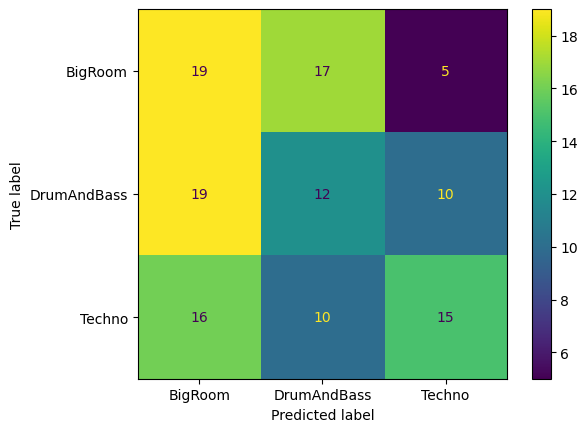

In [19]:
print('The accuracy on the test set is: ' + str(accuracy_score(test_labels, test_predictions)))

# Create the confusion matrix
confusion_mtx = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=['BigRoom', 'DrumAndBass', 'Techno'])

# Plot the confusion matrix
disp.plot()

In [20]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

### SAVE AND LOAD MODEL

In [21]:
model.save('../models/fsm_cnn_8_epochs_80_10_10_adam_categorical_crossentropy_accuracy_rescaled_expanded.h5')

In [22]:
# Loading in the saved model
saved_model = load_model('../models/fsm_cnn_8_epochs_80_10_10_adam_categorical_crossentropy_accuracy_rescaled_expanded.h5')

# FSM 1 HAS AN ACCURACY OF 40%

# Trying a model from

https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab


In [73]:
# # Define the CNN model
# model2 = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(3, activation='softmax')
# ])

In [97]:
model2 = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), 
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (3, 3), activation='relu'),
                    MaxPooling2D((2, 2)),
                    Dropout(0.25),
                    Conv2D(64, (3, 3), activation='relu'),
                    MaxPooling2D(pool_size=(2, 2)),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(3, activation='softmax')])

In [98]:
model2.compile(# optimizer='adam',
               optimizer=tf.keras.optimizers.Adam(learning_rate=6e-4),
#                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
               loss='categorical_crossentropy',
               metrics=['accuracy'])


In [99]:
start_time = time.time()
history = model2.fit_generator(
        train_data_gen,
        steps_per_epoch=train_data_gen.samples // batch_size,
        epochs=6,
        validation_data=validation_data_gen,
        validation_steps=validation_data_gen.samples // batch_size,
        workers=8,
)
print(time.time() - start_time)

Epoch 1/6
31/31 [==============================] - 129s 4s/step - loss: 1.1392 - accuracy: 0.3409 - val_loss: 1.0983 - val_accuracy: 0.3333
Epoch 2/6
31/31 [==============================] - 118s 3s/step - loss: 1.0523 - accuracy: 0.4639 - val_loss: 1.0019 - val_accuracy: 0.4500
Epoch 3/6
31/31 [==============================] - 119s 3s/step - loss: 0.9484 - accuracy: 0.5491 - val_loss: 0.9014 - val_accuracy: 0.6500
Epoch 4/6
31/31 [==============================] - 122s 3s/step - loss: 0.8015 - accuracy: 0.6494 - val_loss: 0.7733 - val_accuracy: 0.6750
Epoch 5/6
31/31 [==============================] - 122s 3s/step - loss: 0.7228 - accuracy: 0.7087 - val_loss: 0.7591 - val_accuracy: 0.6833
Epoch 6/6
31/31 [==============================] - 117s 3s/step - loss: 0.6237 - accuracy: 0.7519 - val_loss: 0.5807 - val_accuracy: 0.7917
739.8871917724609


In [100]:
# Get the predictions for the test set
test_predictions_percentages2 = model2.predict_generator(test_data_gen, steps=test_data_gen.samples // batch_size + 1)
test_predictions2 = np.argmax(test_predictions_percentages2, axis=1)

# Get the true labels for the test set
test_labels = test_data_gen.classes

The accuracy on the test set is: 0.36585365853658536


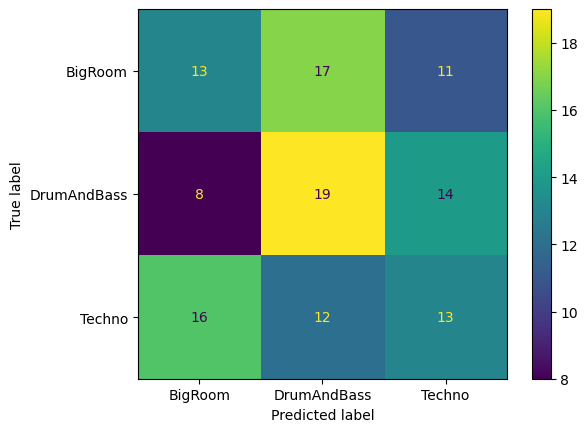

In [101]:
print('The accuracy on the test set is: ' + str(accuracy_score(test_labels, test_predictions2)))

# Create the confusion matrix
confusion_mtx2 = confusion_matrix(test_labels, test_predictions2)

# Plot the confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx2, display_labels=['BigRoom', 'DrumAndBass', 'Techno'])

# Plot the confusion matrix
disp2.plot()

# Plotting Loss and Other Metrics

In [ ]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,21)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()